In [3]:
import pandas as pd

# Load CSV data
df = pd.read_csv('hail-2015.csv')

# Display the first few rows of the dataset
print(df.head())


        X.ZTIME       LON       LAT WSR_ID CELL_ID  RANGE  AZIMUTH  SEVPROB  \
0  2.015010e+13 -97.16003  32.66308   KDFW      C0     27      207        0   
1  2.015010e+13 -97.01849  32.57796   KDAL      E0     21      187        0   
2  2.015010e+13 -97.01735  32.58810   KDFW      J0     29      190        0   
3  2.015010e+13 -96.99553  32.59287   KDAL      E0     20      184        0   
4  2.015010e+13 -96.96180  32.62550   KDAL      E0     18      179        0   

   PROB  MAXSIZE  
0    10      0.5  
1    50      0.5  
2    20      0.5  
3    40      0.5  
4    30      0.5  


In [4]:
# Convert X.ZTIME to datetime format
df['X.ZTIME'] = pd.to_datetime(df['X.ZTIME'], format='%Y%m%d%H%M%S')


In [5]:
# Convert categorical features to numeric using one-hot encoding
df = pd.get_dummies(df, columns=['WSR_ID', 'CELL_ID'])


In [6]:
# Example: Adding a feature that is a combination of RANGE and AZIMUTH
df['RANGE_AZIMUTH'] = df['RANGE'] * df['AZIMUTH']


In [7]:
df.isnull().sum()  # Check for missing values

X.ZTIME          0
LON              0
LAT              0
RANGE            0
AZIMUTH          0
                ..
CELL_ID_Z6       0
CELL_ID_Z7       0
CELL_ID_Z8       0
CELL_ID_Z9       0
RANGE_AZIMUTH    0
Length: 470, dtype: int64

In [8]:
df['X.ZTIME'] = pd.to_datetime(df['X.ZTIME'], format='%Y%m%d%H%M%S')
df['LON'] = pd.to_numeric(df['LON'], errors='coerce')
df['LAT'] = pd.to_numeric(df['LAT'], errors='coerce')
df['SEVPROB'] = pd.to_numeric(df['SEVPROB'], errors='coerce')
df['PROB'] = pd.to_numeric(df['PROB'], errors='coerce')
df['MAXSIZE'] = pd.to_numeric(df['MAXSIZE'], errors='coerce')

In [9]:
from sklearn.model_selection import train_test_split

# Features and target
X = df[['LON', 'LAT', 'RANGE', 'AZIMUTH', 'SEVPROB', 'PROB', 'MAXSIZE', 'RANGE_AZIMUTH']]
y = df['SEVPROB']  # Example target variable

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


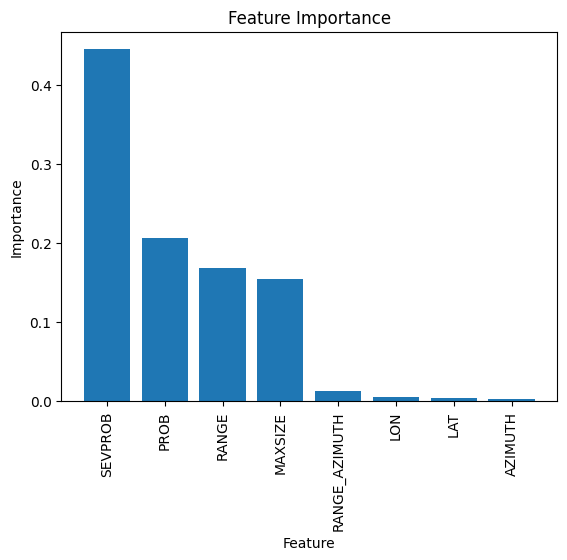

In [10]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot feature importances
plt.figure()
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# Select top features (e.g., top 20)
top_features = X_train.columns[indices[:20]]
X_train_reduced = X_train[top_features]
X_test_reduced = X_test[top_features]


In [11]:
# Check class distribution
print(y_train.value_counts())
print(y_test.value_counts())


SEVPROB
 0      4462685
-999    3004362
 10      330961
 20      257096
 30      195168
 40      141332
 50       99197
 60       66504
 70       43236
 80       27026
 100      15937
 90       15760
Name: count, dtype: int64
SEVPROB
 0      1116259
-999     750510
 10       82405
 20       64510
 30       48634
 40       35545
 50       24641
 60       16775
 70       10748
 80        6792
 100       4052
 90        3945
Name: count, dtype: int64


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

# Initialize model with a different solver
model = LogisticRegression(solver='liblinear', max_iter=2000)

# Initialize RFE
rfe = RFE(model, n_features_to_select=20)
rfe = rfe.fit(X_train, y_train)

# Get selected features
selected_features = X_train.columns[rfe.support_]
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]


In [13]:
model.fit(X_train_reduced, y_train)

LogisticRegression(max_iter=2000, solver='liblinear')

In [14]:
# Option 1: Remove rows with SEVPROB = -999
df = df[df['SEVPROB'] != -999]

# Option 2: Impute with median or mode (not recommended in this case)
# df['SEVPROB'].replace(-999, df['SEVPROB'].median(), inplace=True)


In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_reduced, y_train)


In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

# Make predictions
y_pred = model.predict(X_test_reduced)

# Evaluate model
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

              precision    recall  f1-score   support

        -999       1.00      1.00      1.00    750510
           0       0.97      1.00      0.98   1116259
          10       0.41      0.56      0.48     82405
          20       0.03      0.03      0.03     64510
          30       0.01      0.00      0.00     48634
          40       0.01      0.00      0.00     35545
          50       0.00      0.00      0.00     24641
          60       0.07      0.01      0.02     16775
          70       0.00      0.00      0.00     10748
          80       0.00      0.00      0.00      6792
          90       0.00      0.00      0.00      3945
         100       0.93      1.00      0.96      4052

    accuracy                           0.89   2164816
   macro avg       0.28      0.30      0.29   2164816
weighted avg       0.87      0.89      0.88   2164816

[[ 750510       0       0       0       0       0       0       0       0
        0       0       0]
 [      0 1115306     953       

In [18]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(model, X_train_reduced, y_train, cv=skf)
print(f"Cross-validation scores: {cv_scores}")


Cross-validation scores: [0.8973175  0.8984423  0.88611909 0.88858235 0.88783222]


In [19]:
import pickle

# Save everything that might be needed later
artifacts = {
    'model': model,
    'scaler': scaler,
    'X_train_reduced': X_train_reduced,
    'X_test_reduced': X_test_reduced,
    'y_train': y_train,
    'y_test': y_test,
    'selected_features': selected_features,
    'smote': smote
    
}

# Save to a pickle file
with open('model_artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)


code to run for prediction

In [20]:
# Load the saved artifacts
with open('model_artifacts.pkl', 'rb') as f:
    artifacts = pickle.load(f)

# Extract the saved objects
model = artifacts['model']
scaler = artifacts['scaler']
X_train_reduced = artifacts['X_train_reduced']
X_test_reduced = artifacts['X_test_reduced']
y_train = artifacts['y_train']
y_test = artifacts['y_test']
selected_features = artifacts['selected_features']
smote = artifacts['smote']

# Now you can use model.predict as usual
y_pred = model.predict(X_test_reduced)


In [31]:
import pickle

# Save everything that might be needed later
artifacts = {
    'model': model,
    'scaler': scaler,
    # other artifacts if needed
}

# Save to a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(artifacts['model'], f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(artifacts['scaler'], f)


In [64]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Retrieve the API key
api_key = os.getenv('WEATHER_API_KEY')

# Ensure you handle cases where the API key is not set
if not api_key:
    raise ValueError("API key not found. Please set it in the .env file.")


In [67]:
import pandas as pd
import numpy as np
import pickle
import requests
from sklearn.preprocessing import StandardScaler
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
api_key = os.getenv('WEATHER_API_KEY')

if not api_key:
    raise ValueError("API key not found. Please set it in the .env file.")

# Load the trained model and scaler
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Define the feature names used in training
feature_names = ['LON', 'LAT', 'RANGE', 'AZIMUTH', 'SEVPROB', 'PROB', 'MAXSIZE', 'RANGE_AZIMUTH']

# Define a mapping from model output to weather events
event_mapping = {
    -999: 'No Severe Weather Data',
    0: 'No Severe Weather',
    10: 'Thunderstorm',
    20: 'Hail',
    30: 'Heavy Rain',
    40: 'Tornado',
    50: 'Flood',
    60: 'Snowstorm',
    70: 'High Winds',
    80: 'Blizzard',
    90: 'Freezing Rain',
    100: 'Dust Storm'
}

# Function to get weather data from Weatherbit API
def get_weather_data(longitude, latitude):
    url = f"https://api.weatherbit.io/v2.0/current?lat={latitude}&lon={longitude}&key={api_key}&include=alerts"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        severity_probability = data['data'][0].get('precip', 0)  # Example: Precipitation as severity
        probability = data['data'][0].get('clouds', 0) / 100     # Example: Cloud coverage as probability
        max_size = data['data'][0].get('hail', 2.0)              # Example: Hail size (if available)
        return severity_probability, probability, max_size
    else:
        print(f"Error: Unable to fetch weather data, status code {response.status_code}")
        return 0.5, 0.5, 2.0  # Fallback values

# Function to calculate features
def calculate_features(longitude, latitude):
    severity_probability, probability, max_size = get_weather_data(longitude, latitude)
    range_value = np.sqrt(longitude**2 + latitude**2)
    azimuth = np.arctan2(longitude, latitude) * (180 / np.pi)
    range_azimuth = range_value * azimuth
    
    return {
        'LON': longitude,
        'LAT': latitude,
        'RANGE': range_value,
        'AZIMUTH': azimuth,
        'SEVPROB': severity_probability,
        'PROB': probability,
        'MAXSIZE': max_size,
        'RANGE_AZIMUTH': range_azimuth
    }

# Input from the user
longitude = float(input("Enter the longitude: "))
latitude = float(input("Enter the latitude: "))
month = input("Enter the month of prediction (e.g., October): ")

# Calculate features
features = calculate_features(longitude, latitude)

# Create a DataFrame with the appropriate feature names
input_data = pd.DataFrame([features], columns=feature_names)

# Ensure columns are in the same order as used during fitting
input_data = input_data[feature_names]

# Apply the same transformations to the input data
input_data_scaled = scaler.transform(input_data)

# Make prediction
prediction = model.predict(input_data_scaled)

# Map prediction to a human-readable weather event
event = event_mapping.get(prediction[0], 'Unknown Weather Event')

# Print the final output
print(f"Predicted Weather Event for {month}: {event}")

# Precautionary message
print("Please note that weather predictions are subject to change and should be verified with local weather services.")


Predicted Weather Event for December: No Severe Weather
Please note that weather predictions are subject to change and should be verified with local weather services.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
